In [1]:
from keras.layers import Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img

from glob import glob

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [8]:
IMAGE_SIZE = [100, 100]

epochs = 5
batch_size = 32

train_path = './fruits-360-small/Training'
test_path = './fruits-360-small/Test'

image_files = glob(train_path + '/*/*.jp*g')
test_image_files = glob(test_path + '/*/*.jp*g')

folders = glob(train_path + '/*')

In [9]:
random_image_location = np.random.choice(image_files)

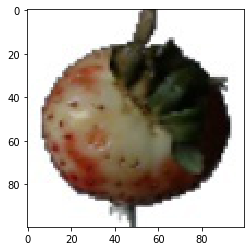

In [10]:
random_image = load_img(random_image_location)
plt.imshow(random_image)
plt.show()

In [11]:
vgg = VGG16(input_shape=IMAGE_SIZE+[3], weights='imagenet', include_top=False)

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 375s 6us/step


In [13]:
# don't train existing weights
for layer in vgg.layers:
    layer.trainable = False

In [14]:
# new layer
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)

In [15]:
# new output layer
prediction = Dense(len(folders), activation='softmax')(x)

In [16]:
# new model object
model = Model(inputs=vgg.input, outputs=prediction)

In [17]:
# show model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0         
__________

In [18]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

In [21]:
# image generator to increase the number of images
gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

In [22]:
test_gen = gen.flow_from_directory(test_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)

Found 496 images belonging to 3 classes.
{'Banana': 0, 'Raspberry': 1, 'Strawberry': 2}


In [24]:
labels = [None] * len(test_gen.class_indices)
labels

[None, None, None]

In [25]:
for k, v in test_gen.class_indices.items():
    labels[v] = k
labels

['Banana', 'Raspberry', 'Strawberry']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


min: -106.63738 max: 151.061


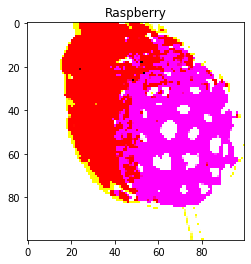

In [30]:
# should be a strangely coloard image due to VGG weights being BGR not RGB
for x, y in test_gen:
    print('min:', x[0].min(), 'max:', x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show
    break

In [32]:
# create generators
train_generator = gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size
)

Found 1472 images belonging to 3 classes.


In [36]:
# fit the model
r = model.fit_generator(
    train_generator,
    validation_data=test_gen,
    epochs=epochs,
    steps_per_epoch=len(image_files) // batch_size,
    validation_steps=len(test_image_files) // batch_size
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
46/46 [==============================] - 8s 185ms/step - loss: 0.2892 - acc: 0.9728 - val_loss: 2.0245e-07 - val_acc: 1.0000
Epoch 2/5
46/46 [==============================] - 3s 57ms/step - loss: 0.0078 - acc: 0.9986 - val_loss: 1.4070e-05 - val_acc: 1.0000
Epoch 3/5
46/46 [==============================] - 3s 62ms/step - loss: 4.0259e-07 - acc: 1.0000 - val_loss: 4.7879e-04 - val_acc: 1.0000
Epoch 4/5
46/46 [==============================] - 3s 62ms/step - loss: 1.2099e-07 - acc: 1.0000 - val_loss: 1.2131e-05 - val_acc: 1.0000
Epoch 5/5
46/46 [==============================] - 3s 62ms/step - loss: 1.1933e-07 - acc: 1.0000 - val_loss: 1.1578e-05 - val_acc: 1.0000


In [42]:
def get_confusion_matrix(data_path, N):
    # we need to see the data in the same order
    # for both predictions and targets
    print('Generating confusion matrix', N)
    predictions = []
    targets = []
    
    test_images = gen.flow_from_directory(
        data_path,
        target_size=IMAGE_SIZE,
        shuffle=False,
        batch_size=batch_size * 2
    )
    
    i = 0
    for x, y in test_images:
        i += 1
        if i%50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break
        
    cm = confusion_matrix(targets, predictions)
    return cm
        

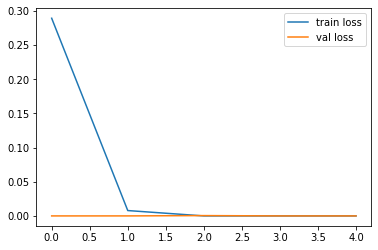

In [43]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

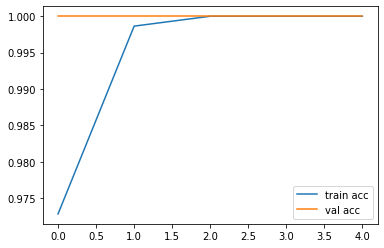

In [44]:
# accuracy
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], label='val acc')
plt.legend()
plt.show()

In [45]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)

Generating confusion matrix 1472
Found 1472 images belonging to 3 classes.
[[490   0   0]
 [  0 490   0]
 [  0   0 492]]


In [46]:
valid_cm = get_confusion_matrix(test_path, len(test_image_files))
print(valid_cm)

Generating confusion matrix 496
Found 496 images belonging to 3 classes.
[[166   0   0]
 [  0 166   0]
 [  0   0 164]]
